In [1]:
import os, pickle
import pandas as pd
import numpy as np
import plotly.express as px
from pycaret.regression import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook, Workbook
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

warnings.filterwarnings("ignore")

In [2]:
## Change the project path
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [14]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'
# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This is how many features you want to keep in the final model
features_threshold = 10

In [10]:
# Set manually date if is necessary
model_run_date = datetime.today().strftime('%Y%m%d')
#model_run_date = '20220504'

In [11]:
items_dicctionary = {
    '11': ('Payroll blended products', True),
    '12': ('W-2 Revenue', False),
    '13': ('Delivery Revenue', False),
    '14': ('ASO Allocation', False),
    '15': ('Other Processing Revenue', False),
    '16': ('SurePayroll.', True),
    '17': ('Total international', False),
    '21': ('401K Fee Revenue', True),
    '22': ('401K Asset fee & BP Revenue', True),
    '23': ('HR Solutions (PEO)', False),
    '24': ('ASO Revenue - Oasis', False),
    '31': ('HR Online', False),
    '32': ('Time & Attendance', False),
    '41': ('Total Paychex Advance', True),
    '42': ('Full Service Unemployment Revenue',  True),
    '43': ('ESR Revenue', True),
    '44': ('Cafeteria Plans Revenue',  True),
    '45': ('Benetrac', True),
    '46': ('Emerging Products', True),
    '51': ('Total PEO', False),
    '61': ('Workers Comp - Payment Services', True),
    '62': ('Health Benefits', True),
    '71': ('Interest on Funds Held for Clients', False)
}

In [39]:
# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
# target_col = 'Payroll blended products'
# has_drivers = True
# target_col = 'W-2 Revenue'
# has_drivers = False
# target_col = 'Delivery Revenue'
# has_drivers = False
# target_col = 'ASO Allocation'
# has_drivers = False
# target_col = 'Other Processing Revenue'
# has_drivers = False
# target_col = 'SurePayroll.'
# has_drivers = True
# target_col = 'Total international'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
# target_col = '401K Fee Revenue'
# has_drivers = True
# target_col = '401K Asset fee & BP Revenue'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total ASO Revenue
# ------------------------------------------------------------------------------------- #
# target_col = 'HR Solutions (PEO)'
# has_drivers = False
# target_col = 'ASO Revenue - Oasis'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Online Services
# ------------------------------------------------------------------------------------- #
# target_col = 'HR Online'
# has_drivers = False
# target_col = 'Time & Attendance'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Other Management Solutions
# ------------------------------------------------------------------------------------- #
# target_col = 'Total Paychex Advance'
# has_drivers = True
# target_col = 'Full Service Unemployment Revenue'
# has_drivers = True
# target_col = 'ESR Revenue'
# has_drivers = True
# target_col = 'Cafeteria Plans Revenue'
# has_drivers = True
# target_col = 'Benetrac'
# has_drivers = True
# target_col = 'Emerging Products'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total PEO
# ------------------------------------------------------------------------------------- #
# target_col = 'Total PEO'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Insurance Services
# ------------------------------------------------------------------------------------- #
# target_col = 'Workers Comp - Payment Services'
# has_drivers = True
# target_col = 'Health Benefits'
# has_drivers = True

# target_col = 'Interest on Funds Held for Clients'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Level 1
# ------------------------------------------------------------------------------------- #
# target_col = 'Total Payroll Revenue.'
# has_drivers = True
target_col = 'Total 401k'
has_drivers = True
# target_col = 'Total ASO Revenue'
# has_drivers = False
# target_col = 'Total Online Services'
# has_drivers = True
# target_col = 'Other Management Solutions'
# has_drivers = True
# target_col = 'Total Insurance Services'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total Level 2
# ------------------------------------------------------------------------------------- #
# target_col = 'Total Revenue'
# has_drivers = False



In [40]:
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [plan_col,fcst_col,ml_col,uts_col]
has_actuals = True
level = 1

In [41]:
# Get the full data frame and combine with drivers
#all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)

In [42]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, level=level)

In [43]:
drive_path = proyect_path+"/data/clean/table_drivers.csv"
#driv_df_ = pd.read_csv(file_path, dtype={'Period':str, 'Calendar Date': str})
#driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, file_path)

In [44]:
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

In [45]:
external_path = proyect_path+"/data/external/external_data_fred.csv"
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})
#ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

In [ ]:
model_path = "./data/models/"+model_run_date
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print("Directory created")

In [46]:
# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

Shape of the training dataframe:
(72, 135)
Shape of the testing dataframe:
(12, 135)
Shape of the combination dataframe:
(84, 135)


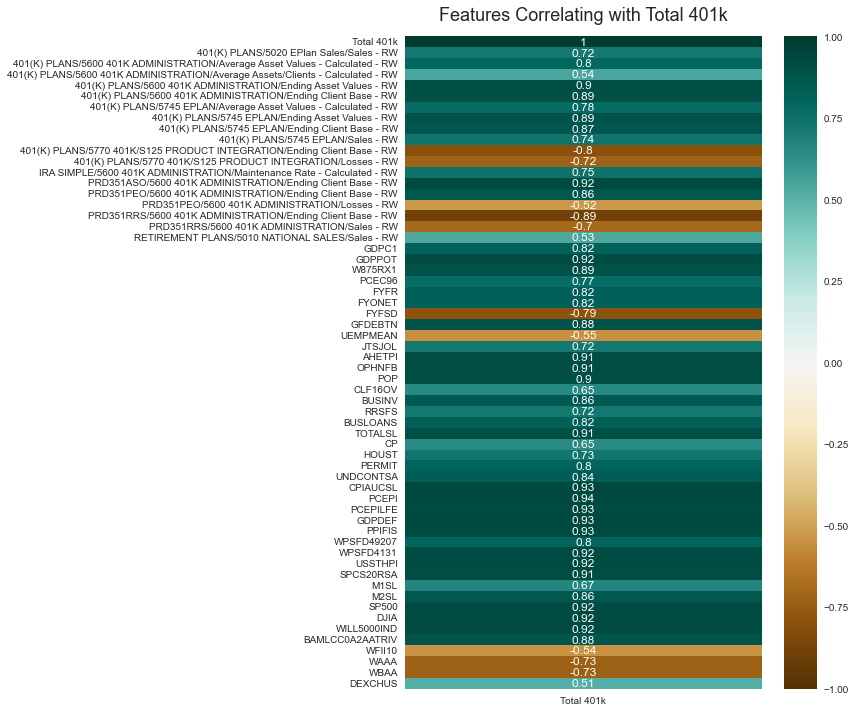

In [47]:
feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
corr_df = corr_df[corr_df[target_col].abs() >= correlation_threshold]

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

In [48]:
# Get a list of the features based on correlation
corr_df = corr_df.rename_axis('Feature').reset_index()
corr_feature_cols = corr_df['Feature'].tolist()
corr_feature_cols.remove(target_col)
#print(corr_feature_cols)

In [49]:
# run auto ml and get the most important features
best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1063579.1036,1901722880959.4617,1357589.8348,-1.8802,0.0695,0.0552,0.0100
llar,Lasso Least Angle Regression,1229873.0698,3123622862786.7134,1648960.3610,-4.7656,0.0886,0.0647,0.0200
huber,Huber Regressor,1343519.9767,4809924450442.0781,2136535.7030,-5.1997,0.1006,0.0710,0.0100
gbr,Gradient Boosting Regressor,1390408.5103,3213448950121.7925,1688127.1393,-2.3300,0.0898,0.0714,0.0267
rf,Random Forest Regressor,1452877.0594,3525604882093.2417,1742626.5609,-2.2885,0.0919,0.0731,0.0667
et,Extra Trees Regressor,1536877.3543,3523839749248.6875,1813437.8276,-2.6998,0.0954,0.0779,0.0600
dt,Decision Tree Regressor,1541899.0185,4074147190529.9814,2003576.2257,-4.1331,0.1078,0.0801,0.0100
xgboost,Extreme Gradient Boosting,1593258.6250,4221956259840.0000,1966903.8750,-3.4825,0.1050,0.0815,0.1033
br,Bayesian Ridge,1628784.3664,4412090346510.2197,1858140.9669,-3.1837,0.1002,0.0830,0.0133
ada,AdaBoost Regressor,1706775.2042,4664710199459.6201,2007485.5191,-3.1751,0.1057,0.0848,0.0333


<class 'sklearn.linear_model._omp.OrthogonalMatchingPursuit'>


In [50]:
ml_features = models.get_important_features('xgboost', features_threshold)
ml_feature_cols = ml_features['Feature'].tolist()

if len(ml_features.index) != 0:
    # plot the most important features
    fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance',
                 y='Feature',
                 orientation='h',
                 title='Feature Importance Plot')
    fig.show()

In [51]:
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #


# Here we need to figure out which set of features we want to use
# ml_features or corr_features
feature_cols = ml_feature_cols
#feature_cols = corr_feature_cols

feature_cols = ml_feature_cols
keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,918615.8033,1338910415786.4744,1137649.8992,-1.2044,0.0594,0.0482,0.0100
gbr,Gradient Boosting Regressor,1187970.4521,2383309312649.1689,1434753.5652,-1.3739,0.0750,0.0602,0.0200
xgboost,Extreme Gradient Boosting,1265008.8125,2602695502506.6665,1540012.6250,-2.2716,0.0823,0.0657,0.1033
et,Extra Trees Regressor,1305147.6039,2698809861624.7930,1571322.0407,-1.7749,0.0815,0.0658,0.0567
rf,Random Forest Regressor,1307334.2222,2794813279047.8008,1559776.3509,-1.7367,0.0814,0.0661,0.0933
dt,Decision Tree Regressor,1368162.3148,3223851537432.6484,1707460.7853,-2.7520,0.0904,0.0707,0.0133
ada,AdaBoost Regressor,1454513.9964,3252586875028.9321,1722363.5106,-2.2919,0.0901,0.0734,0.0267
knn,K Neighbors Regressor,1553490.8750,3626842740053.3335,1789273.5000,-2.3538,0.0936,0.0776,0.0100
par,Passive Aggressive Regressor,1587928.1940,17592402770572.4492,3223756.0476,-12.8155,0.1143,0.0786,0.0100
lightgbm,Light Gradient Boosting Machine,1617299.0338,4279488391468.3335,1859547.9476,-2.7861,0.0980,0.0808,0.0200


<class 'sklearn.linear_model._omp.OrthogonalMatchingPursuit'>


In [52]:
# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

In [53]:
act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
act_df = act_df[['Calendar Date', target_col]]
act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])

In [ ]:
pipeline, name = save_model(best, model_path + '/{}_model'.format(target_col))

In [54]:
# create the future predictions dataframe
if has_actuals:
    pred_df, _ = models.run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window, ci=False)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df = pred_df.rename(columns={'Label':ml_col})[['Calendar Date', ml_col]]
    concat_df = pd.merge(act_df, pred_df ,on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, type='plan', level=level)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path,
                                type='forecast',
                                forecast_type=forecast_type,
                                level=level)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

############################  Running Auto ARIMA for SP500   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=890.402, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=916.967, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=890.271, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=888.474, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=914.983, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=889.102, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=889.418, Time=0.61 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=890.254, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=887.578, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=887.420, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=888.578, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=889.385, Time=0.60 sec
 ARIMA(0,1,0)

In [55]:
# run UTS
uts_df = comb_df[['Calendar Date', target_col]]
uts_df, uts_model = models.run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window, ci=True)
uts_df.rename(columns={target_col:uts_col}, inplace=True)

############################  Running Auto ARIMA for Total 401k   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2159.218, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2186.395, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2166.004, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2161.132, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2186.898, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2155.319, Time=0.38 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2168.754, Time=0.14 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2155.987, Time=1.14 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2156.440, Time=0.92 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2154.446, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2159.835, Time=0.25 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2158.960, Time=0.28 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=2155.189, Time=

In [ ]:
with open(model_path + '/{}_uts_model.pkl'.format(target_col), 'wb') as pkl:
    pickle.dump(uts_model, pkl)

In [56]:
concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')

In [57]:
# combine all data together
concat_df = pd.concat([comb_df[['Calendar Date', target_col]],concat_df], axis=0)

In [58]:
# show plot
fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
fig.show()

In [59]:
# compute mape_df
mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
mape_df = models.compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
mape_df = mape_df.rename(index={True:'MAPE'})
mape_df = pd.concat([mape_df.reset_index(drop=True), uts_df], axis=1)

In [60]:
mape_df

,Calendar Date,Total 401k,Total 401k - Plan,Total 401k - Plan - APE,Total 401k - 2+10 Forecast,Total 401k - 2+10 Forecast - APE,Total 401k - ML Predicted,Total 401k - ML Predicted - APE,Total 401k - UTS Predicted,Total 401k - UTS Predicted - APE,Calendar Date,Total 401k - UTS Predicted,Lower CI,Upper CI
0,2021-06-01 00:00:00,24192008.0,23661269.0,0.021939,24192008.0,0.000000,2.833407e+07,0.171216,2.331134e+07,0.036403,2021-06-01,2.331134e+07,2.154444e+07,2.507823e+07
1,2021-07-01 00:00:00,24136555.0,24203741.0,0.002784,24136555.0,0.000000,2.867635e+07,0.188088,2.416575e+07,0.001210,2021-07-01,2.416575e+07,2.185199e+07,2.647951e+07
2,2021-08-01 00:00:00,24432497.0,24366204.0,0.002713,24573159.0,0.005757,2.837195e+07,0.161238,2.405135e+07,0.015600,2021-08-01,2.405135e+07,2.115989e+07,2.694281e+07
3,2021-09-01 00:00:00,27574022.0,26002241.0,0.057002,26129436.0,0.052389,2.991271e+07,0.084815,2.631462e+07,0.045674,2021-09-01,2.631462e+07,2.304671e+07,2.958252e+07
4,2021-10-01 00:00:00,24476676.0,24309070.0,0.006848,24438467.0,0.001561,2.877960e+07,0.175797,2.422927e+07,0.010108,2021-10-01,2.422927e+07,2.054161e+07,2.791693e+07
5,2021-11-01 00:00:00,25836220.0,23991424.0,0.071403,24119241.0,0.066456,2.906397e+07,0.124931,2.417545e+07,0.064281,2021-11-01,2.417545e+07,2.017719e+07,2.817370e+07
6,2021-12-01 00:00:00,26002179.0,24841928.0,0.044621,24976139.0,0.039460,2.903327e+07,0.116570,2.509498e+07,0.034889,2021-12-01,2.509498e+07,2.075461e+07,2.943536e+07
7,2022-01-01 00:00:00,25826263.0,25329871.0,0.019220,25457133.0,0.014293,3.084975e+07,0.194511,2.491909e+07,0.035126,2022-01-01,2.491909e+07,2.030608e+07,2.953210e+07
8,NaN,NaN,NaN,0.028316,NaN,0.022490,NaN,0.152146,NaN,0.030411,NaT,NaN,NaN,NaN


In [61]:
metadata_path = proyect_path + "/data/metadata/"
mape_path = metadata_path + model_run_date + "_mape.xlsx"
if os.path.exists(mape_path):
    book = load_workbook(mape_path)
else:
    book = Workbook()
with pd.ExcelWriter(mape_path, engine = 'openpyxl') as writer:
    writer.book = book
    mape_df.to_excel(writer, sheet_name = target_col[0:30], index=False)

In [108]:
concat_df[concat_df['Calendar Date'] >= pred_start_dt]

,Calendar Date,Interest on Funds Held for Clients,Interest on Funds Held for Clients - ML Predicted,Interest on Funds Held for Clients - Plan,Interest on Funds Held for Clients - 2+10 Forecast,Interest on Funds Held for Clients - UTS Predicted,Interest on Funds Held for Clients_lower_ci,Interest on Funds Held for Clients_upper_ci
0,2021-06-01,-451367.0,8.838785e+06,4687137.0,-451367.0,-2.347883e+06,-6.770667e+06,2.074901e+06
1,2021-07-01,-386211.0,8.533176e+06,4727006.0,-386211.0,-2.033447e+06,-6.937266e+06,2.870372e+06
2,2021-08-01,-398389.0,8.225735e+06,5402709.0,4648749.0,-2.398601e+06,-7.740311e+06,2.943108e+06
3,2021-09-01,-517688.0,8.291251e+06,4636944.0,4637734.0,-2.446004e+06,-8.192332e+06,3.300325e+06
4,2021-10-01,-414842.0,8.413610e+06,4684411.0,4686972.0,-2.314003e+06,-8.438276e+06,3.810269e+06
5,2021-11-01,-462587.0,8.583186e+06,5397348.0,4644354.0,-2.502411e+06,-8.982622e+06,3.977800e+06
6,2021-12-01,-325405.0,8.568823e+06,4840579.0,4846830.0,-1.748759e+06,-8.566351e+06,5.068833e+06
7,2022-01-01,-311881.0,8.383558e+06,4756334.0,4760590.0,-1.905915e+06,-9.044961e+06,5.233132e+06


In [98]:
predictions_path = proyect_path+"/data/predictions/"+model_run_date
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)
    print("Directory created")

Directory created


In [210]:
df_write = concat_df.rename(columns={target_col: 'Actual',
                           ml_col: 'ML Predicted',
                           uts_col: 'UTS Predicted',
                           plan_col: 'Plan',
                           fcst_col:' Forecast'})

In [76]:
df_write['Item'] = target_col

In [77]:
df_write

,Calendar Date,Actual,ML Predicted,Plan,Forecast,UTS Predicted,Item
0,2014-06-01,2.074346e+08,NaN,NaN,NaN,NaN,Total Revenue
1,2014-07-01,2.483619e+08,NaN,NaN,NaN,NaN,Total Revenue
2,2014-08-01,2.110434e+08,NaN,NaN,NaN,NaN,Total Revenue
3,2014-09-01,2.064182e+08,NaN,NaN,NaN,NaN,Total Revenue
4,2014-10-01,2.584593e+08,NaN,NaN,NaN,NaN,Total Revenue
...,...,...,...,...,...,...,...
3,2021-09-01,3.709236e+08,3.331832e+08,3.567864e+08,6.990509e+08,3.560265e+08,Total Revenue
4,2021-10-01,3.574400e+08,3.399423e+08,3.410163e+08,6.567897e+08,3.609818e+08,Total Revenue
5,2021-11-01,3.646379e+08,3.448046e+08,3.480824e+08,6.753844e+08,3.510391e+08,Total Revenue
6,2021-12-01,4.078692e+08,3.495820e+08,3.752561e+08,7.258485e+08,3.833378e+08,Total Revenue


In [78]:
df_write.to_parquet(predictions_path+"/"+target_col.replace(" ","")+".parquet")

In [101]:
mape_df

,Calendar Date,Interest on Funds Held for Clients,Interest on Funds Held for Clients - Plan,Interest on Funds Held for Clients - Plan - APE,Interest on Funds Held for Clients - 2+10 Forecast,Interest on Funds Held for Clients - 2+10 Forecast - APE,Interest on Funds Held for Clients - ML Predicted,Interest on Funds Held for Clients - ML Predicted - APE,Interest on Funds Held for Clients - UTS Predicted,Interest on Funds Held for Clients - UTS Predicted - APE,Calendar Date,Interest on Funds Held for Clients - UTS Predicted,Interest on Funds Held for Clients_lower_ci,Interest on Funds Held for Clients_upper_ci
0,2021-06-01 00:00:00,-451367.0,4687137.0,-11.384315,-451367.0,-0.000000,8.838785e+06,-20.582257,-2.347883e+06,-4.201716,2021-06-01,-2.347883e+06,-6.770667e+06,2.074901e+06
1,2021-07-01 00:00:00,-386211.0,4727006.0,-13.239439,-386211.0,-0.000000,8.533176e+06,-23.094595,-2.033447e+06,-4.265120,2021-07-01,-2.033447e+06,-6.937266e+06,2.870372e+06
2,2021-08-01 00:00:00,-398389.0,5402709.0,-14.561391,4648749.0,-12.668869,8.225735e+06,-21.647496,-2.398601e+06,-5.020752,2021-08-01,-2.398601e+06,-7.740311e+06,2.943108e+06
3,2021-09-01 00:00:00,-517688.0,4636944.0,-9.957024,4637734.0,-9.958550,8.291251e+06,-17.015923,-2.446004e+06,-3.724861,2021-09-01,-2.446004e+06,-8.192332e+06,3.300325e+06
4,2021-10-01 00:00:00,-414842.0,4684411.0,-12.292036,4686972.0,-12.298210,8.413610e+06,-21.281480,-2.314003e+06,-4.578035,2021-10-01,-2.314003e+06,-8.438276e+06,3.810269e+06
5,2021-11-01 00:00:00,-462587.0,5397348.0,-12.667747,4644354.0,-11.039958,8.583186e+06,-19.554750,-2.502411e+06,-4.409600,2021-11-01,-2.502411e+06,-8.982622e+06,3.977800e+06
6,2021-12-01 00:00:00,-325405.0,4840579.0,-15.875552,4846830.0,-15.894762,8.568823e+06,-27.332795,-1.748759e+06,-4.374099,2021-12-01,-1.748759e+06,-8.566351e+06,5.068833e+06
7,2022-01-01 00:00:00,-311881.0,4756334.0,-16.250477,4760590.0,-16.264123,8.383558e+06,-27.880631,-1.905915e+06,-5.111032,2022-01-01,-1.905915e+06,-9.044961e+06,5.233132e+06
8,NaN,NaN,NaN,-13.278498,NaN,-9.765559,NaN,-22.298741,NaN,-4.460652,NaT,NaN,NaN,NaN


In [158]:
df = pd.read_parquet("C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/data/predictions/20220509")

In [159]:
df

,Calendar Date,Item,Actual,ML Predicted,UTS Predicted,Plan,Forecast,Lower CI,Upper CI
0,2021-06-01,Delivery Revenue,7.829827e+06,8.742005e+06,7.621582e+06,7.486713e+06,7.829827e+06,5.679662e+06,9.563501e+06
1,2021-07-01,Delivery Revenue,1.243936e+07,1.289055e+07,1.218767e+07,1.261072e+07,1.243936e+07,1.005493e+07,1.432041e+07
2,2021-08-01,Delivery Revenue,7.622602e+06,7.869987e+06,7.427974e+06,7.556542e+06,7.682000e+06,4.843065e+06,1.001288e+07
3,2021-09-01,Delivery Revenue,7.779041e+06,7.976084e+06,7.893044e+06,6.818278e+06,7.149703e+06,5.066063e+06,1.072002e+07
4,2021-10-01,Delivery Revenue,1.126827e+07,1.287066e+07,1.247308e+07,1.174251e+07,1.122409e+07,9.354347e+06,1.559181e+07
5,2021-11-01,Delivery Revenue,7.617424e+06,7.695706e+06,7.406496e+06,6.938894e+06,7.147250e+06,4.056574e+06,1.075642e+07
6,2021-12-01,Delivery Revenue,8.212787e+06,8.042708e+06,8.094190e+06,7.564224e+06,7.716521e+06,4.510080e+06,1.167830e+07
7,2022-01-01,Delivery Revenue,2.243552e+07,2.102415e+07,2.258278e+07,2.262883e+07,2.207458e+07,1.878818e+07,2.637738e+07
8,2021-06-01,Payroll blended products,1.142380e+08,1.069185e+08,1.145630e+08,1.134306e+08,1.142380e+08,9.281367e+07,1.363124e+08
9,2021-07-01,Payroll blended products,1.131859e+08,1.110458e+08,1.157635e+08,1.143207e+08,1.131859e+08,9.176588e+07,1.397611e+08
